# Degradation example


This juypter notebook is intended to test the degradation analysis workflow.  In addition, the notebook demonstrates the effects of changes in the workflow.

Degradation analysis of PV systems includes several steps:
1. <b>Standardize</b> data inputs
2. <b>Normalize</b> data using a performance metric
3. <b>Filter</b> data that creates bias 
4. <b>Analyze</b> aggregated data to estimate the degradation rate



In [1]:
# Enable inline plotting
%matplotlib inline

# Backport python3 division behavior
from __future__ import division

from urllib import urlencode
import datetime
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import os

import pytz
from pprint import pprint

from sklearn.linear_model import LinearRegression
import seaborn as sns

# Set plotting configuration
sns.set_palette('deep', desat=.8)
sns.set_context('notebook', font_scale=1.5, rc={'figure.figsize': (16,5)})
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 24}
plt.rc('font', **font)

import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })

In [2]:
import pvlib
import rdtools

print pvlib.__version__
print rdtools.__version__

/Users/anag/anaconda/envs/python2.7/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


0.4.5
1.0.1+31.gc86550c.dirty


# 1. <b>Standardize</b>

Please download the annual csv data for system with system id 39, using the PVDAQ API, and store the csv file in the folder:
./rdtools/docs/

https://developer.nrel.gov/docs/solar/pvdaq-v3/data_file/

The following script loads the data, parses a pandas.DateTimeIndex, and renames the critical pandas.Series objects.



In [3]:
systemid=39
api_key='ZRHhZvBE4s40rAkPi1A1jyyjOA4KIF5ULinBPmEd'
pvdaq_metadata_url = 'http://developer.nrel.gov/api/pvdaq/v3/sites.xml?system_id=' + str(systemid) + '&api_key=' + api_key

In [4]:
pvdaq_metadata_url

'http://developer.nrel.gov/api/pvdaq/v3/sites.xml?system_id=39&api_key=ZRHhZvBE4s40rAkPi1A1jyyjOA4KIF5ULinBPmEd'

In [5]:
import urllib2
import xmltodict
import xml.etree.ElementTree as et

file = urllib2.urlopen(pvdaq_metadata_url)
tree = et.parse(file)
file.close()

root = tree.getroot()



avail_year = [int(avail_year.text) for avail_year in root.iter('available-year')]
start_year = avail_year[0]
end_year = avail_year[-1]
inverter_mfg = [str(inv_mfg.text) for inv_mfg in root.iter('inverter-mfg')][0]
inverter_model = [str(inv_model.text) for inv_model in root.iter('inverter-model')][0]
module_mfg = [str(mod_mfg.text) for mod_mfg in root.iter('module-mfg')][0]
module_model = [str(mod_model.text) for mod_model in root.iter('module-model')][0]
power = [float(site_power.text) for site_power in root.iter('site-power')][0]
area = [float(site_area.text) for site_area in root.iter('site-area')][0]
azimuth = [float(site_azimuth.text) for site_azimuth in root.iter('site-azimuth')][0]
elevation = [float(site_elevation.text) for site_elevation in root.iter('site-elevation')][0]
lat = [float(site_lat.text) for site_lat in root.iter('site-latitude')][0]
lon = [float(site_lon.text) for site_lon in root.iter('site-longitude')][0]
lon = -lon
tilt = [float(site_tilt.text) for site_tilt in root.iter('site-tilt')][0]
name = [str(name_priv.text) for name_priv in root.iter('name-private')][0]

In [6]:
avail_year

[1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017]

In [7]:
year = 2002
pvdaq_ann_csv_url = 'http://developer.nrel.gov/api/pvdaq/v3/data_file.csv?api_key=' + api_key + '&system_id=' + str(systemid)+ '&year=' + str(year)

In [8]:
pvdaq_ann_csv_url

'http://developer.nrel.gov/api/pvdaq/v3/data_file.csv?api_key=ZRHhZvBE4s40rAkPi1A1jyyjOA4KIF5ULinBPmEd&system_id=39&year=2002'

In [9]:
list_years = avail_year[9:]

In [10]:
list_years

[2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017]

In [12]:
df = pd.DataFrame()

for year in list_years:
    pvdaq_ann_csv_url = 'http://developer.nrel.gov/api/pvdaq/v3/data_file.csv?api_key=' + api_key + '&system_id=' + str(systemid)+ '&year=' + str(year)
    data = pd.read_csv(pvdaq_ann_csv_url)
    df = df.append(data)
    

In [13]:
df.head()

,ACVA,ACVar,AC_VARhoursnet,AC_Watthoursnet,DC_power,Date-Time,EPO_Status,EPO_status,GH_irradiance,Module10NW_Temp,...,unbiased_module_temp_3_2,unbiased_module_temp_3_3,unbiased_temp,wetness_kOhms,wind_direction,wind_direction_unc,wind_speed,wind_speed_unc,wind_speed_xvec,wind_speed_yvec
0,NaN,NaN,NaN,NaN,NaN,2004-01-01 00:00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,2004-01-01 00:15:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,2004-01-01 00:30:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,2004-01-01 00:45:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,2004-01-01 01:00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
type(df['Date-Time'])

pandas.core.series.Series

In [15]:
df['Date-Time'] = pd.to_datetime(df['Date-Time'])

In [16]:
df.set_index('Date-Time', inplace=True)

In [17]:
df.index

DatetimeIndex(['2004-01-01 00:00:00', '2004-01-01 00:15:00',
               '2004-01-01 00:30:00', '2004-01-01 00:45:00',
               '2004-01-01 01:00:00', '2004-01-01 01:15:00',
               '2004-01-01 01:30:00', '2004-01-01 01:45:00',
               '2004-01-01 02:00:00', '2004-01-01 02:15:00',
               ...
               '2017-07-20 03:31:00', '2017-07-20 03:32:00',
               '2017-07-20 03:33:00', '2017-07-20 03:34:00',
               '2017-07-20 03:35:00', '2017-07-20 03:36:00',
               '2017-07-20 03:37:00', '2017-07-20 03:38:00',
               '2017-07-20 03:39:00', '2017-07-20 03:40:00'],
              dtype='datetime64[ns]', name=u'Date-Time', length=4061703, freq=None)

In [18]:
df = df.resample('15T').mean()

In [19]:
print pd.infer_freq(df.index)

15T


In [20]:
timezone = pytz.timezone("Etc/GMT+7")
df.index = df.index.tz_localize(timezone)

In [21]:
module_temp = df.filter(regex=("module_temp*"))
module_temp = module_temp.median(axis=1)
df['module_temperature'] = module_temp

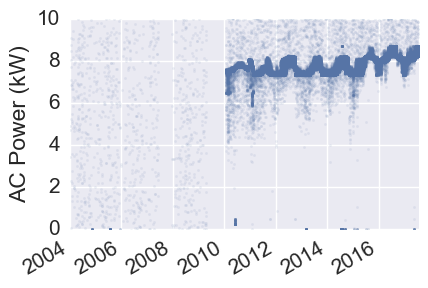

In [22]:
# downsample
df = df.asfreq('15T') 

# plot the AC power time series
fig, ax = plt.subplots()
ax.plot(df.index, df.ac_power, 'o', alpha = 0.1)
ax.set_ylim(0,10)
fig.autofmt_xdate()
ax.set_ylabel('AC Power (kW)');

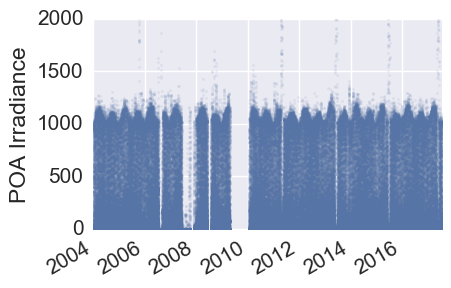

In [23]:
# plot the POA irradiance time series
fig, ax = plt.subplots()
ax.plot(df.index, df.poa_irradiance, 'o', alpha = 0.1)
ax.set_ylim(0,2000)
fig.autofmt_xdate()
ax.set_ylabel('POA Irradiance');

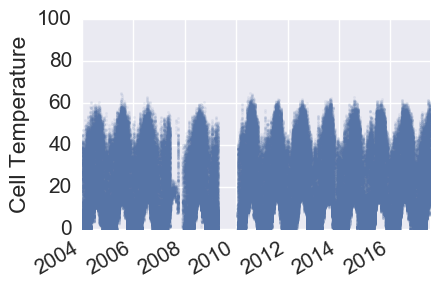

In [24]:
# plot the cell temperature time series
fig, ax = plt.subplots()
ax.plot(df.index, df.module_temperature, 'o', alpha = 0.1)
ax.set_ylim(0,100)
fig.autofmt_xdate()
ax.set_ylabel('Cell Temperature');

# 2. <b>Normalize</b> 

Data normalization typically requires some additional metadata about the PV system power time series.  Metadata consists of site location information, module product details, PV circuit configuration, and other items.

<15 * Minutes>


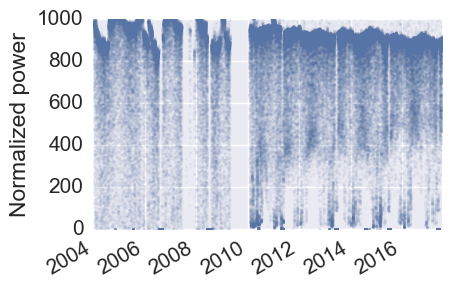

In [25]:
# Metadata
pdc = 1.4 # System size in kW

pvwatts_kws = {"poa_global" : df.poa_irradiance,
              "P_ref" : pdc,
              "T_cell" : df.module_temperature,
              "G_ref" : 1000,
              "T_ref" : 20,
              "gamma_pdc" : -0.00506}

normalized = rdtools.normalize_with_pvwatts(df.ac_power, pvwatts_kws)


# Plot the normalized power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.set_ylim(0,1000)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

In [26]:
normalized.head(n=50)

Date-Time
2004-01-01 00:00:00-07:00     3472.937611
2004-01-01 00:15:00-07:00     4506.928605
2004-01-01 00:30:00-07:00    10752.764945
2004-01-01 00:45:00-07:00     6129.482477
2004-01-01 01:00:00-07:00     4306.791618
2004-01-01 01:15:00-07:00     3244.711855
2004-01-01 01:30:00-07:00     2978.581879
2004-01-01 01:45:00-07:00     3250.468202
2004-01-01 02:00:00-07:00     3056.686796
2004-01-01 02:15:00-07:00     3036.656441
2004-01-01 02:30:00-07:00     4018.907746
2004-01-01 02:45:00-07:00     3946.450297
2004-01-01 03:00:00-07:00     3418.659977
2004-01-01 03:15:00-07:00     5687.090271
2004-01-01 03:30:00-07:00     3853.966792
2004-01-01 03:45:00-07:00     4808.204174
2004-01-01 04:00:00-07:00     6162.272288
2004-01-01 04:15:00-07:00     3362.893473
2004-01-01 04:30:00-07:00     2979.167813
2004-01-01 04:45:00-07:00     3175.792569
2004-01-01 05:00:00-07:00     4936.247814
2004-01-01 05:15:00-07:00     5327.067014
2004-01-01 05:30:00-07:00     3598.806139
2004-01-01 05:45:00-07:0

# 3. <b>Filter</b> 

Data filtering is used to exclude data points that represent invalid data, create bias in the analysis, or introduce significant noise.


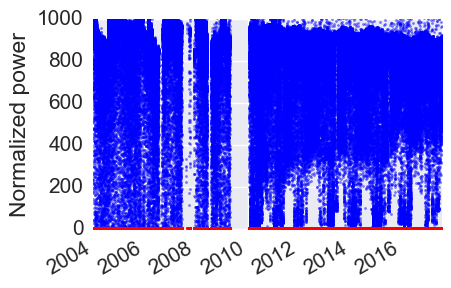

In [27]:
# Perform rudimetary filtering, more advanced filtering will be integrated
# into Rdtools in the future

df['normalized'] = normalized
#filter_criteria = ((df['normalized']>0) & (df['normalized']<2) & (df.poa_irradiance>200))
filter_criteria = ((df['normalized']>750) & (df['normalized']<1000) & (df.poa_irradiance>200))

filtered = df[filter_criteria]['normalized']




#after filtering, center the data at PR_t0 = 1
def center_data(series):
    v = series.resample('12M').median().max()    
    return series / v

filtered = center_data(filtered)


# Plot the normalized and filtered power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', color='b', alpha = 0.5)
ax.plot(filtered.index, filtered, 'o', color='r', alpha = 0.5)
ax.set_ylim(0,1000)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

In [28]:
filtered

Date-Time
2004-01-01 08:15:00-07:00    0.848894
2004-01-01 08:30:00-07:00    0.928439
2004-01-01 08:45:00-07:00    0.979427
2004-01-01 09:00:00-07:00    0.969912
2004-01-01 09:15:00-07:00    0.924589
2004-01-01 09:30:00-07:00    1.000604
2004-01-01 09:45:00-07:00    1.022679
2004-01-01 10:00:00-07:00    0.965420
2004-01-01 10:15:00-07:00    0.961609
2004-01-01 10:30:00-07:00    1.012404
2004-01-01 10:45:00-07:00    1.006937
2004-01-01 11:00:00-07:00    1.021220
2004-01-01 11:15:00-07:00    1.031224
2004-01-01 11:30:00-07:00    1.027153
2004-01-01 11:45:00-07:00    1.011637
2004-01-01 12:00:00-07:00    1.020329
2004-01-01 12:15:00-07:00    1.016469
2004-01-01 12:30:00-07:00    1.002768
2004-01-01 12:45:00-07:00    1.032224
2004-01-01 13:00:00-07:00    1.031310
2004-01-01 13:15:00-07:00    1.037479
2004-01-01 13:30:00-07:00    1.045011
2004-01-01 13:45:00-07:00    1.039462
2004-01-01 14:00:00-07:00    0.987384
2004-01-01 15:45:00-07:00    1.024401
2004-01-02 08:45:00-07:00    0.843151
20

# 4. <b>Analyze</b>

Data is then analyzed to estimate the degradation rate representing the PV system behavior.  The data may or may not be aggregated by this step.  



In [29]:
ols_rd, ols_ci, ols_info = rdtools.degradation.degradation_ols(filtered)
print '''The degradation rate calculated with ols is %0.2f %%/year
with a confidence interval of %0.2f to %0.2f %%/year''' % (ols_rd, ols_ci[0], ols_ci[1])

# yoy = rdtools.degradation.degradation_year_on_year(filtered)
# print "degradation_year_on_year", yoy

The degradation rate calculated with ols is -0.25 %/year
with a confidence interval of -0.25 to -0.24 %/year


In [30]:
filtered.index

DatetimeIndex(['2004-01-01 08:15:00-07:00', '2004-01-01 08:30:00-07:00',
               '2004-01-01 08:45:00-07:00', '2004-01-01 09:00:00-07:00',
               '2004-01-01 09:15:00-07:00', '2004-01-01 09:30:00-07:00',
               '2004-01-01 09:45:00-07:00', '2004-01-01 10:00:00-07:00',
               '2004-01-01 10:15:00-07:00', '2004-01-01 10:30:00-07:00',
               ...
               '2017-07-19 11:30:00-07:00', '2017-07-19 11:45:00-07:00',
               '2017-07-19 12:00:00-07:00', '2017-07-19 12:15:00-07:00',
               '2017-07-19 12:30:00-07:00', '2017-07-19 12:45:00-07:00',
               '2017-07-19 13:15:00-07:00', '2017-07-19 13:30:00-07:00',
               '2017-07-19 13:45:00-07:00', '2017-07-19 14:00:00-07:00'],
              dtype='datetime64[ns, Etc/GMT+7]', name=u'Date-Time', length=107977, freq=None)

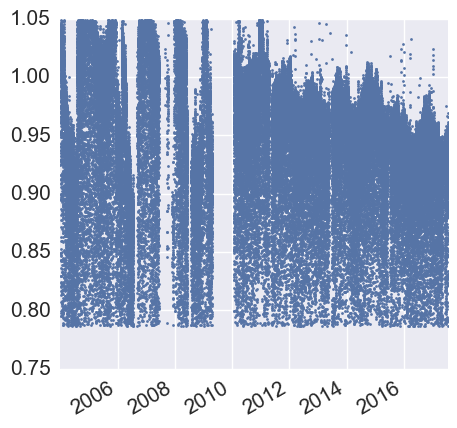

In [31]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(filtered.index, filtered, 'o', alpha = 1.0)
fig.autofmt_xdate()

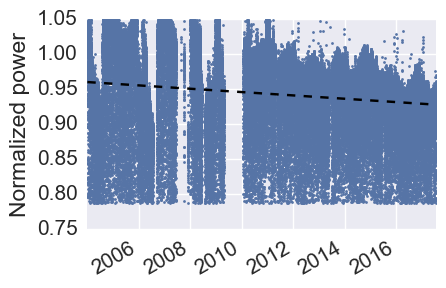

In [32]:
# plot the regression through the normalized data 
fig, ax = plt.subplots()
ax.plot(filtered.index, filtered, 'o', alpha = 1.0)
x_vals = np.array(ax.get_xlim())
y_vals = ols_info['intercept'] + ols_info['slope'] * (x_vals-min(x_vals)) / 365
ax.plot(x_vals, y_vals, '--k')

#ax.set_ylim(0,1.4)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

In [33]:
# Plot the year-on-year distribution
# YoY_filtered1 = yoy['YoY_filtered']
# YOY_median = yoy['Rd_median']
# plt.hist(YoY_filtered1, alpha=0.5, label='YOY', bins=int(YoY_filtered1.__len__()/4))
# plt.axvline(x=YOY_median, color='black', linestyle='dashed', linewidth=3)
# #plt.legend(loc='upper right')
# plt.title('Year-on-Year 15-minute Distribution \n Data outside +/-100 removed')   
# plt.tight_layout(w_pad=1, h_pad=2.0)
# plt.xlabel('Annual degradation (%)')